In [1]:
# Offline version of classification will not know the order of stroke points when classifying
# Learn from MNIST database to identify strokes instead of determining with geometry-based features
# Because there is no distinction between self-loops and vertices, we can ignore this entirely

# The primary distinguishing factor between vertices and self-loops is their size
# MNIST dataset does not distinguish between the size of 0's, so it must be handled manually afterward

# Treat all 0 as true label of a vertex or loop
# Treat all 1 as true label of a line
# Treat all 7 as true label of an arrow
# Ignore all other inputs

# Ignore all other labels
# Base network architecture referenced from https://arxiv.org/abs/2008.10400v2
# Rather than implementing the voting scheme, we just take one CNN and train it

In [77]:
import tensorflow as tf
import numpy as np
import keras
from tensorflow import image
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


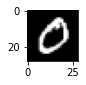

In [165]:
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train, x_test = x_train.astype("float32") / 255, x_test.astype("float32") / 255

# Remove all digits [3:6] and [8:9]

indices_train = np.sort(np.append(np.nonzero(y_train < 2), np.nonzero(y_train == 7)))
indices_test = np.sort(np.append(np.nonzero(y_test < 2), np.nonzero(y_test == 7)))

x_train = x_train[indices_train]
x_test = x_test[indices_test]
y_train = y_train[indices_train]
y_test = y_test[indices_test]

y_train[y_train == 7] = 2
y_test[y_test == 7] = 2

fig = plt.figure(figsize=(x_train[0].shape[0] / 30, x_train[0].shape[1] / 30))
plt.imshow(x_train[0], cmap='gray', aspect='equal')

In [87]:
y_train=tf.keras.utils.to_categorical(y_train,3)
y_test=tf.keras.utils.to_categorical(y_test,3)
x_train=np.expand_dims(x_train,axis=-1)
x_test=np.expand_dims(x_test,axis=-1)

print(x_test.shape)


(3143, 28, 28, 1)


In [136]:
model = keras.Sequential(
    [
        keras.Input(shape=(28,28,1)),
        layers.RandomRotation(1),
        layers.Conv2D(64, kernel_size=(5, 5), activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(5, 5), activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(3, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation_3 (RandomRo  (None, 28, 28, 1)        0         
 tation)                                                         
                                                                 
 conv2d_6 (Conv2D)           (None, 24, 24, 64)        1664      
                                                                 
 batch_normalization_6 (Batc  (None, 24, 24, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 128)         204928    
                                                      

In [137]:
batch_size = 120
epochs = 5

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/5
142/142 [==============================] - 21s 143ms/step - loss: 0.1161 - accuracy: 0.9647 - val_loss: 1.1041 - val_accuracy: 0.3555
Epoch 2/5
142/142 [==============================] - 19s 135ms/step - loss: 0.0467 - accuracy: 0.9850 - val_loss: 1.8570 - val_accuracy: 0.3111
Epoch 3/5
142/142 [==============================] - 20s 141ms/step - loss: 0.0454 - accuracy: 0.9863 - val_loss: 1.0939 - val_accuracy: 0.4643
Epoch 4/5
142/142 [==============================] - 20s 141ms/step - loss: 0.0370 - accuracy: 0.9886 - val_loss: 0.0251 - val_accuracy: 0.9921
Epoch 5/5
142/142 [==============================] - 20s 140ms/step - loss: 0.0345 - accuracy: 0.9896 - val_loss: 0.0191 - val_accuracy: 0.9926


In [138]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.02581162005662918
Test accuracy: 0.993318498134613


In [9]:
from ipywidgets import Image
from ipywidgets import ColorPicker, IntSlider, link, AppLayout, HBox
from ipycanvas import RoughCanvas, Canvas, hold_canvas

import numpy as np

In [10]:
width = 100
height = 100

In [166]:
#Set up canvas
canvas = Canvas(width=width, height=height, sync_image_data=True)
canvas.line_width = 8

drawing = False
position = None
points = np.zeros((2,0))
shape = []


def on_mouse_down(x, y):
    global drawing
    global position
    global shape
    global points

    drawing = True
    position = (x, y)
    shape = [position]


def on_mouse_move(x, y):
    global drawing
    global position
    global shape
    global points

    if not drawing:
        return

    with hold_canvas(canvas):
        canvas.stroke_line(position[0], position[1], x, y)

        position = (x, y)

    shape.append(position)


def on_mouse_up(x, y):
    global drawing
    global position
    global shape
    global points

    drawing = False
    
    with hold_canvas(canvas):
        canvas.stroke_line(position[0], position[1], x, y)
    
    points = np.append(points,shape)

    shape = []


canvas.on_mouse_down(on_mouse_down)
canvas.on_mouse_move(on_mouse_move)
canvas.on_mouse_up(on_mouse_up)

canvas.stroke_style = '#000000'

canvas.scale = 10
canvas.layout.border_width = 3
canvas.layout.border = 'solid'
canvas.layout.border_color = '#000000'

In [179]:
canvas

Canvas(height=100, image_data=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00d\x00\x00\x00d\x08\x06\x00\x00\…

[[0. 0. 1.]]


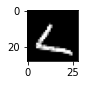

In [188]:
# Get the image from the canvas
stroke_img = canvas.get_image_data()

stroke_img = np.sum(stroke_img, axis = 2) / 3
# Invert image data

stroke_img=np.expand_dims(stroke_img,axis=-1)

stroke_img = image.resize(stroke_img, (28, 28)) 
stroke_img = np.array(stroke_img, dtype = 'int32') 
#stroke_img = np.invert(stroke_img) + 1


fig = plt.figure(figsize=(stroke_img.shape[0] / 30, stroke_img.shape[1] / 30))
plt.imshow(stroke_img, cmap='gray', aspect='equal')

stroke_img = np.expand_dims(stroke_img,axis=0)
print(model.predict(stroke_img))

In [187]:
canvas.clear()